In [1]:
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import Input, merge, UpSampling2D,BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import tensorflow as tf

import matplotlib.pyplot as plt
import skimage.io as io
from glob import glob

import numpy as np
import random as r
import cv2

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
tf.__version__

'2.4.1'

In [3]:
!pip install simpleitk

In [4]:
path = "/content/drive/MyDrive/BraTS/subset/HGG/"

In [5]:
files = glob(path+"**/*flair.nii.gz")

len(files)

36

# Convert to Array

In [6]:
first_img = io.imread(files[1], plugin="simpleitk")

print(f"shape: {first_img.shape}")
print(f"dtype: {first_img.dtype}")

shape: (155, 240, 240)
dtype: int16


## Visualize Flair Image

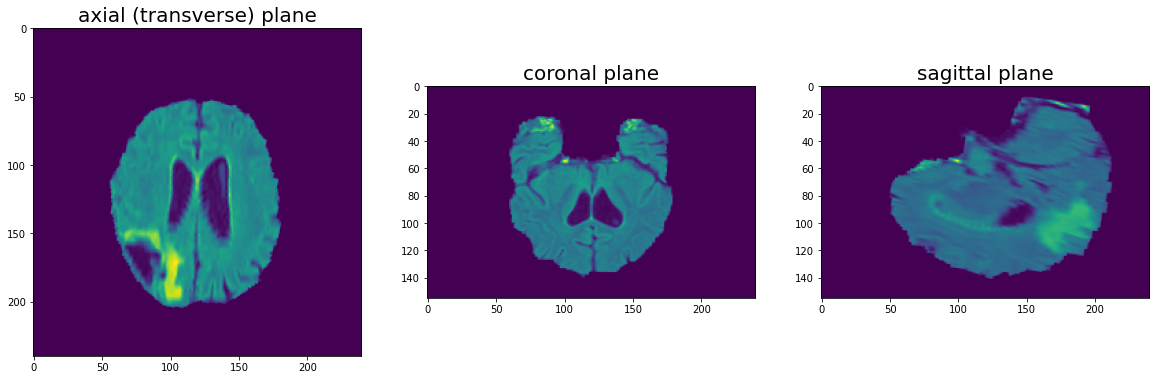

In [7]:
fig = plt.figure(figsize=(20,15))

ax1 = fig.add_subplot(1,3,1)
ax1.imshow(first_img[100,:,:])
plt.title("axial (transverse) plane", fontsize=20)

ax2 = fig.add_subplot(1,3,2)
ax2.imshow(first_img[:,100,:])
plt.title("coronal plane", fontsize=20)

ax3 = fig.add_subplot(1,3,3)
ax3.imshow(first_img[:,:,100])
plt.title("sagittal plane", fontsize=20);

## Visualize Segmented Image

In [8]:
files[1]

'/content/drive/MyDrive/BraTS/subset/HGG/BraTS19_2013_19_1/BraTS19_2013_19_1_flair.nii.gz'

In [9]:
seg_img = io.imread('/content/drive/MyDrive/BraTS/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_11_1/BraTS19_2013_11_1_seg.nii.gz', plugin="simpleitk")

print(f"shape: {seg_img.shape}")
print(f"dtype: {seg_img.dtype}")

shape: (155, 240, 240)
dtype: int16


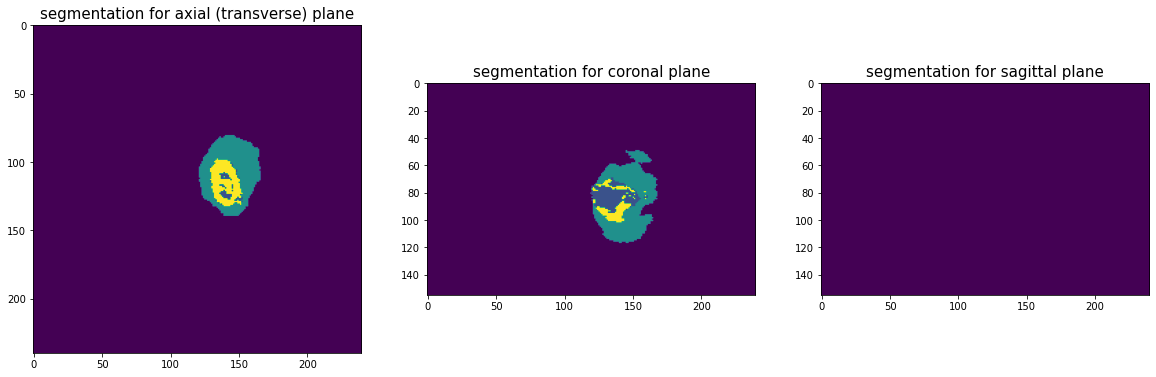

In [10]:
fig = plt.figure(figsize=(20,15))

ax1 = fig.add_subplot(1,3,1)
ax1.imshow(seg_img[100,:,:])
plt.title("segmentation for axial (transverse) plane", fontsize=15)

ax2 = fig.add_subplot(1,3,2)
ax2.imshow(seg_img[:,100,:])
plt.title("segmentation for coronal plane", fontsize=15)

ax3 = fig.add_subplot(1,3,3)
ax3.imshow(seg_img[:,:,100])
plt.title("segmentation for sagittal plane", fontsize=15);

# Convert to Array 

In [11]:
def to_array(path, end):
    
    # get locations
    files = glob(path+end, recursive=True)
    
    img_list = []
    
    r.seed(42)
    r.shuffle(files)
    
    for file in files:
        img = io.imread(file, plugin="simpleitk")

        # standardization
        img = (img-img.mean())/img.std()
        img.astype("float32")
        
        for slice in range(60, 90):
            img_s = img[slice,:,:]
            
            # resize
            img_s = cv2.resize(img_s, (128,128))
            
            img_s = np.expand_dims(img_s, axis=0)
            img_list.append(img_s)
            
    return np.array(img_list,np.float32)

### np.expand_dims()

In [12]:
first_img.shape

(155, 240, 240)

In [13]:
exp = first_img[60,:,:]

exp.shape

(240, 240)

In [14]:
exp = np.expand_dims(exp, axis=0)

exp.shape

(1, 240, 240)

# Applying the Function

In [15]:
train = to_array(path=path, end="**/*flair.nii.gz")

In [16]:
train.shape

(1080, 1, 128, 128)

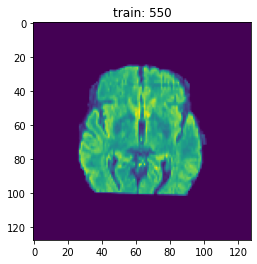

In [17]:
plt.imshow(train[550].reshape(128,128))
plt.title("train: 550");

In [18]:
t1ce = to_array(path=path, end='**/*t1ce.nii.gz')

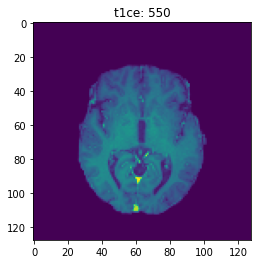

In [19]:
plt.imshow(t1ce[550].reshape(128,128))
plt.title("t1ce: 550");

# Segmented Images

1 - Non-enhancing Tumor

2 - Edema 

4 - Enhancing Tumor

In [20]:
seg_img.shape

(155, 240, 240)

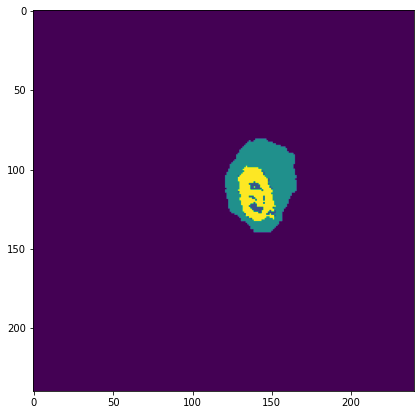

In [21]:
plt.figure(figsize=(7,7))
plt.imshow(seg_img[100,:,:]);

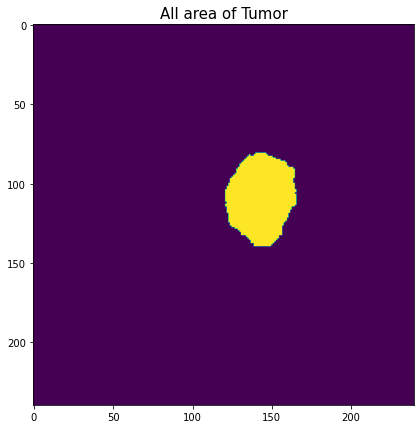

In [22]:
seg_all = seg_img.copy()

seg_all[seg_all != 0] = 1 # show all tumor area

plt.figure(figsize=(7,7))
plt.imshow(seg_all[100,:,:])
plt.title("All area of Tumor", fontsize=15);

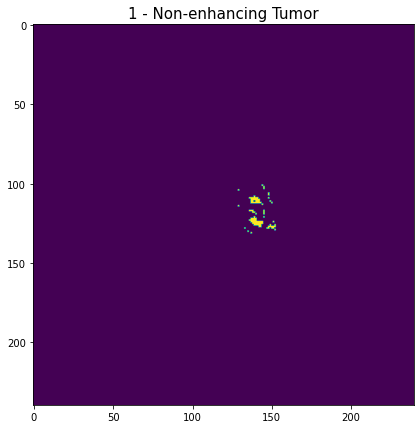

In [23]:
seg_non = seg_img.copy()

seg_non[seg_non != 1] = 0 # show non-enhancing tumor

plt.figure(figsize=(7,7))
plt.imshow(seg_non[100,:,:])
plt.title("1 - Non-enhancing Tumor", fontsize=15);

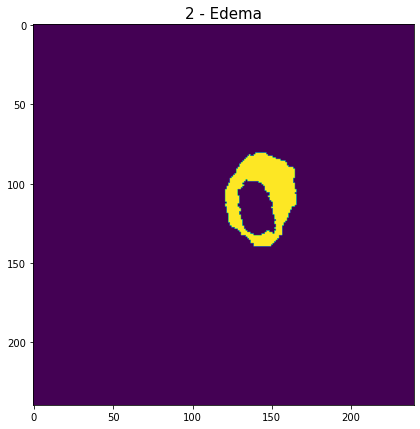

In [24]:
seg_edema = seg_img.copy()

seg_edema[seg_edema == 1] = 0 # cover Non-enhancing Tumor
seg_edema[seg_edema == 4] = 0 # cover Enhancing Tumor
seg_edema[seg_edema != 0] = 1 # show Edema

plt.figure(figsize=(7,7))
plt.imshow(seg_edema[100,:,:])
plt.title("2 - Edema", fontsize=15);

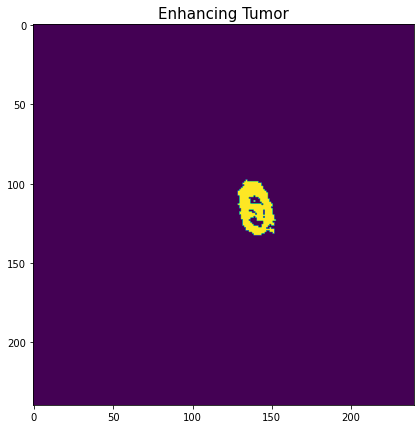

In [25]:
seg_enhancing = seg_img.copy()

seg_enhancing[seg_enhancing != 4] = 0 # show Enhancing Tumor

plt.figure(figsize=(7,7))
plt.imshow(seg_enhancing[100,:,:])
plt.title("Enhancing Tumor", fontsize=15);

# To Array for Segmented Images

In [26]:
def seg_to_array(path, end, label):
    
    # get locations
    files = glob(path+end, recursive=True)
    
    img_list = []
    
    r.seed(42)
    r.shuffle(files)
    
    for file in files:
        img = io.imread(file, plugin="simpleitk")
        
        # all tumor
        if label == 1:
            img[img != 0] = 1
        
        # Non-enhancing Tumor
        if label == 2:
            img[img != 1] = 0
        
        # Without Edema
        if label == 3:
            img[img == 2] = 0
            img[img != 0] = 1
        
        # Enhancing Tumor
        if label == 4:
            img[img != 4] = 0
            img[img == 4] = 1
            

        img.astype("float32")
        
        for slice in range(60, 90):
            img_s = img[slice,:,:]
            
            # resize
            img_s = cv2.resize(img_s, (128,128))
            
            img_s = np.expand_dims(img_s, axis=0)
            img_list.append(img_s)
            
    return np.array(img_list,np.float32)

In [27]:
seg_all_tumor = seg_to_array(path=path, end="**/*seg.nii.gz", label=1)

seg_non_enhancing = seg_to_array(path=path, end="**/*seg.nii.gz", label=2)

seg_out_edema = seg_to_array(path=path, end="**/*seg.nii.gz", label=3) 

seg_enhancing = seg_to_array(path=path, end="**/*seg.nii.gz", label=4) 

seg_original = seg_to_array(path=path, end="**/*seg.nii.gz", label=0)

In [28]:
seg_all_tumor.shape

(1080, 1, 128, 128)

In [29]:
seg_non_enhancing.shape

(1080, 1, 128, 128)

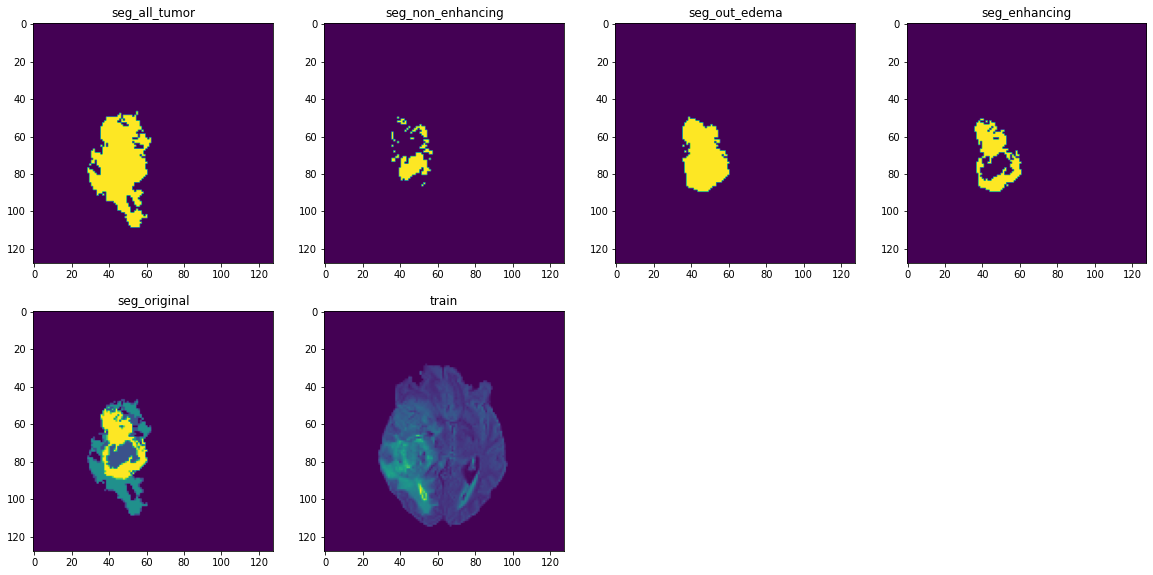

In [30]:
idx = 1000

plt.figure(figsize=(20,15))

plt.subplot(3,4,1)
plt.imshow(seg_all_tumor[idx].reshape(128,128))
plt.title("seg_all_tumor")

plt.subplot(3,4,2)
plt.imshow(seg_non_enhancing[idx].reshape(128,128))
plt.title("seg_non_enhancing")

plt.subplot(3,4,3)
plt.imshow(seg_out_edema[idx].reshape(128,128))
plt.title("seg_out_edema")

plt.subplot(3,4,4)
plt.imshow(seg_enhancing[idx].reshape(128,128))
plt.title("seg_enhancing")

plt.subplot(3,4,5)
plt.imshow(seg_original[idx].reshape(128,128))
plt.title("seg_original")

plt.subplot(3,4,6)
plt.imshow(train[idx].reshape(128,128))
plt.title("train");

# U-NET MODEL

In [31]:
flair = to_array(path=path, end="**/*flair.nii.gz")
t2 = to_array(path=path, end="**/*t2.nii.gz")
seg = seg_to_array(path=path, end="**/*seg.nii.gz", label=1)

In [32]:
flair.shape, t2.shape, seg.shape

((1080, 1, 128, 128), (1080, 1, 128, 128), (1080, 1, 128, 128))

## Concatenate

In [33]:
X_train = np.concatenate((flair, t2), axis=1)

In [34]:
X_train.shape

(1080, 2, 128, 128)

In [35]:
X_train.dtype

dtype('float32')

# U-NET MODEL

In [36]:
def dice_coef(y_true, y_pred):
    smooth = 0.005 
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)
    

K.set_image_data_format('channels_first')


def unet():
    
    inputs = Input((2, 128 , 128))
    
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same') (inputs)
    batch1 = BatchNormalization(axis=1)(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same') (batch1)
    batch1 = BatchNormalization(axis=1)(conv1)
    pool1 = MaxPooling2D((2, 2))(batch1)
    
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same') (pool1)
    batch2 = BatchNormalization(axis=1)(conv2)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same') (batch2)
    batch2 = BatchNormalization(axis=1)(conv2)
    pool2 = MaxPooling2D((2, 2))(batch2)
    
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (pool2)
    batch3 = BatchNormalization(axis=1)(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch3)
    batch3 = BatchNormalization(axis=1)(conv3)
    pool3 = MaxPooling2D((2, 2))(batch3)
    
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same') (pool3)
    batch4 = BatchNormalization(axis=1)(conv4)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same') (batch4)
    batch4 = BatchNormalization(axis=1)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(batch4)
    
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same') (pool4)
    batch5 = BatchNormalization(axis=1)(conv5)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same') (batch5)
    batch5 = BatchNormalization(axis=1)(conv5)
    
    up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same') (batch5)
    up6 = concatenate([up6, conv4], axis=1)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same') (up6)
    batch6 = BatchNormalization(axis=1)(conv6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same') (batch6)
    batch6 = BatchNormalization(axis=1)(conv6)
    
    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (batch6)
    up7 = concatenate([up7, conv3], axis=1)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same') (up7)
    batch7 = BatchNormalization(axis=1)(conv7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch7)
    batch7 = BatchNormalization(axis=1)(conv7)
    
    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (batch7)
    up8 = concatenate([up8, conv2], axis=1)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same') (up8)
    batch8 = BatchNormalization(axis=1)(conv8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same') (batch8)
    batch8 = BatchNormalization(axis=1)(conv8)
    
    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (batch8)
    up9 = concatenate([up9, conv1], axis=1)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (up9)
    batch9 = BatchNormalization(axis=1)(conv9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (batch9)
    batch9 = BatchNormalization(axis=1)(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(batch9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-4), loss=dice_coef_loss, metrics=[dice_coef])

    return model

In [37]:
model = unet()

In [38]:
model.fit(X_train, seg, validation_split=0.25, batch_size=32, epochs=50, shuffle=True)

Epoch 1/25
26/26 [==============================] - 21s 518ms/step - loss: 0.8994 - dice_coef: 0.1005 - val_loss: 0.8919 - val_dice_coef: 0.1013
Epoch 2/25
26/26 [==============================] - 10s 392ms/step - loss: 0.8399 - dice_coef: 0.1602 - val_loss: 0.8687 - val_dice_coef: 0.1232
Epoch 3/25
26/26 [==============================] - 10s 395ms/step - loss: 0.7739 - dice_coef: 0.2262 - val_loss: 0.8558 - val_dice_coef: 0.1353
Epoch 4/25
26/26 [==============================] - 10s 396ms/step - loss: 0.7316 - dice_coef: 0.2685 - val_loss: 0.8625 - val_dice_coef: 0.1290
Epoch 5/25
26/26 [==============================] - 10s 397ms/step - loss: 0.7110 - dice_coef: 0.2891 - val_loss: 0.8732 - val_dice_coef: 0.1189
Epoch 6/25
26/26 [==============================] - 10s 397ms/step - loss: 0.7015 - dice_coef: 0.2988 - val_loss: 0.8524 - val_dice_coef: 0.1384
Epoch 7/25
26/26 [==============================] - 10s 401ms/step - loss: 0.6845 - dice_coef: 0.3156 - val_loss: 0.8453 - val_dic

In [39]:
model.save_weights("/content/drive/MyDrive/BraTS/subset_model.h5")

# PREDICTION

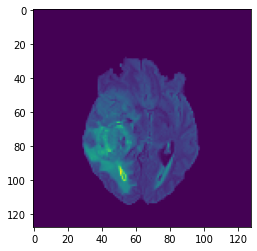

In [53]:
plt.imshow(X_train[1000][0]);

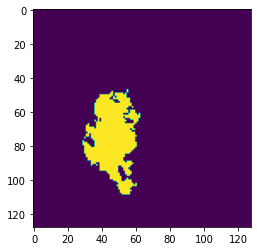

In [54]:
plt.imshow(seg[1000][0]);

In [55]:
expand_img = np.expand_dims(X_train[1000], axis=0)

pred = model.predict(expand_img)

## Visualize Prediction

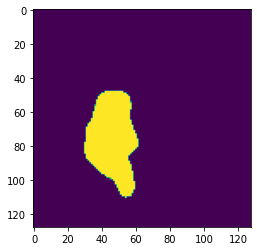

In [56]:
plt.imshow(pred[0][0]);

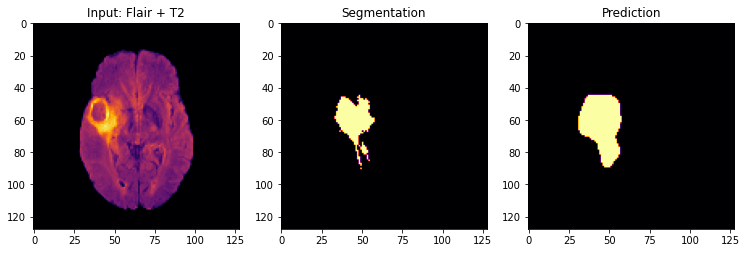

In [60]:
x = 333

sample = np.expand_dims(X_train[x], axis=0)
pred = model.predict(sample)


fig = plt.figure(figsize=(17, 15))

plt.subplot(1,4,1)
plt.title("Input: Flair + T2")
plt.imshow(X_train[x][0], cmap="inferno")

plt.subplot(1,4,2)
plt.title("Segmentation")
plt.imshow(seg[x][0], cmap="inferno")

plt.subplot(1,4,3)
plt.title("Prediction")
plt.imshow(pred[0][0], cmap="inferno");

# Cropping Images

 * First Step: 
  * Get coordinates of Tumor Center
 * Step Two:
  * Threshold
 * Step Three
  * Get coordinates that are equals 1

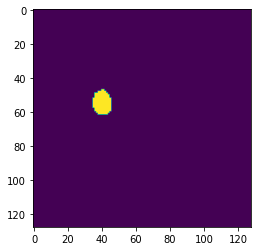

In [61]:
tmp = seg_out_edema[333,0,:,:]

tmp.shape

plt.imshow(tmp);

In [62]:
# threshold
tmp[tmp > 0.2] = 1
tmp[tmp != 1] = 0

In [63]:
index_xy = np.where(tmp==1)

In [64]:
index_xy[0]

array([47, 47, 48, 48, 48, 48, 48, 49, 49, 49, 49, 49, 49, 49, 49, 50, 50,
       50, 50, 50, 50, 50, 50, 50, 51, 51, 51, 51, 51, 51, 51, 51, 51, 52,
       52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 53, 53, 53, 53, 53, 53, 53,
       53, 53, 53, 53, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 55, 55,
       55, 55, 55, 55, 55, 55, 55, 55, 55, 56, 56, 56, 56, 56, 56, 56, 56,
       56, 56, 56, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 58, 58, 58,
       58, 58, 58, 58, 58, 58, 58, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59,
       60, 60, 60, 60, 60, 60, 60, 60, 61, 61, 61, 61, 61, 61])

In [65]:
index_xy[1]

array([40, 41, 38, 39, 40, 41, 42, 36, 37, 38, 39, 40, 41, 42, 43, 36, 37,
       38, 39, 40, 41, 42, 43, 44, 36, 37, 38, 39, 40, 41, 42, 43, 44, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 35, 36, 37, 38, 39, 40, 41,
       42, 43, 44, 45, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 35, 36, 37, 38, 39, 40, 41, 42,
       43, 44, 45, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 36, 37, 38,
       39, 40, 41, 42, 43, 44, 45, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
       37, 38, 39, 40, 41, 42, 43, 44, 38, 39, 40, 41, 42, 43])

In [66]:
center_y = (max(index_xy[0]) + min(index_xy[0])) / 2

center_y

54.0

In [67]:
center_x = (max(index_xy[1]) + min(index_xy[1])) / 2

center_x

40.0

In [68]:
img_x = np.zeros((64,64), np.float32)

img_x.shape

(64, 64)

In [71]:
x = t1ce[333,0,:,:]
x.shape

(128, 128)

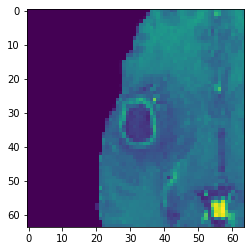

In [72]:
img_x[:,:] = x[int(center_y - 64/2): int(center_y + 64/2), int(center_x - 64/2): int(center_x + 64/2)]


plt.imshow(img_x);

In [73]:
seg_ = seg_out_edema[333,0,:,:]

seg_.shape

(128, 128)

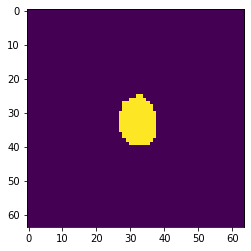

In [74]:
img_x[:,:] = seg_[int(center_y - 64/2): int(center_y + 64/2), int(center_x - 64/2): int(center_x + 64/2)]


plt.imshow(img_x);

In [75]:
def crop_tumor(mr, seg):
  
  mr = mr[0]
  list_ = []

  # thresholding
  tmp = seg[0,:,:]
  tmp[tmp > 0.2] = 1
  tmp[tmp != 1] = 0
  index_xy = np.where(tmp==1)

  # some images contain no tumor !
  if index_xy[0] != []:

    center_y = (max(index_xy[0]) + min(index_xy[0])) / 2
    center_x = (max(index_xy[1]) + min(index_xy[1])) / 2

    img_x = np.zeros((64,64), np.float32)

    img_x[:,:] = mr[int(center_y - 64/2):int(center_y + 64/2), int(center_x - 64/2):int(center_x + 64/2)]

    list_.append(img_x)
  
  return np.array(list_)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  del sys.path[0]


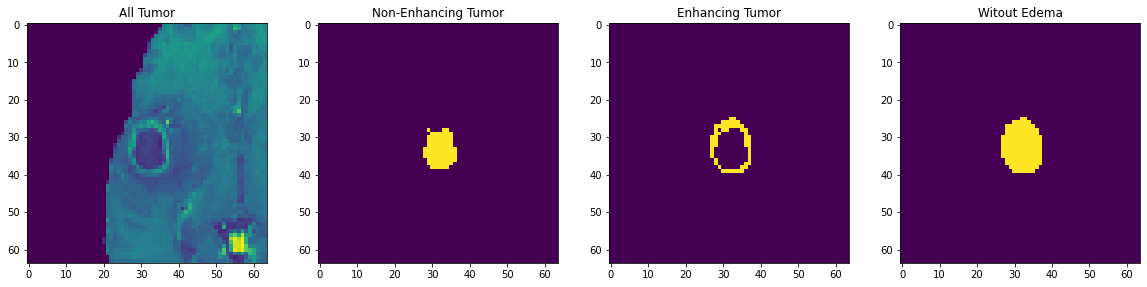

In [76]:
img_333 = crop_tumor(mr=t1ce[333], seg=seg_out_edema[333])
non_333 = crop_tumor(mr=seg_non_enhancing[333], seg=seg_out_edema[333])
enhancing_333 = crop_tumor(mr=seg_enhancing[333], seg=seg_out_edema[333])
without_edema_333 = crop_tumor(mr=seg_out_edema[333], seg=seg_out_edema[333])


plt.figure(figsize=(20,15))

plt.subplot(3,4,1)
plt.imshow(img_333[0])
plt.title("All Tumor")

plt.subplot(3,4,2)
plt.imshow(non_333[0])
plt.title("Non-Enhancing Tumor")

plt.subplot(3,4,3)
plt.imshow(enhancing_333[0])
plt.title("Enhancing Tumor")

plt.subplot(3,4,4)
plt.imshow(without_edema_333[0])
plt.title("Witout Edema");

In [77]:
def tumor_to_array(tumor, segmentation):

  im_list = []

  for i in range(len(segmentation)):
    img = crop_tumor(tumor[i], seg_out_edema[i])

    if len(img.shape) > 2:
      im_list.append(img)

  return np.array(im_list)

In [78]:
without_edema = tumor_to_array(seg_out_edema, seg_out_edema)
enhancing = tumor_to_array(seg_enhancing, seg_out_edema)
t1ce_crop = tumor_to_array(t1ce, seg_out_edema)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  del sys.path[0]
